In [14]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [15]:
import json
import tensorflow as tf
import csv
import requests
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from urllib.request import urlopen


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [16]:
num_sentences = 0

with open(r"D:\codebase\coursera\dlaicourse\TensorFlow In Practice\Course 3 - NLP\training_cleaned.csv" , encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item = []
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [17]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [18]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer( )
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:training_size]
test_labels = labels[:split]
training_labels = labels[split:training_size]

In [19]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138626
1


In [20]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier

TXT_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'


embeddings_index = {}
with open(r'D:\codebase\coursera\dlaicourse\TensorFlow In Practice\Course 3 - NLP\glove.6B.100d.txt',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [21]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138627


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')# YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           13862700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 13,927,853
Trainable params: 65,153
Non-trainable params: 13,862,700
_____________________________________

In [24]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")


Epoch 1/50
4500/4500 - 12s - loss: 0.5281 - accuracy: 0.7318 - val_loss: 0.5082 - val_accuracy: 0.7471
Epoch 2/50
4500/4500 - 12s - loss: 0.5104 - accuracy: 0.7441 - val_loss: 0.5009 - val_accuracy: 0.7554
Epoch 3/50
4500/4500 - 12s - loss: 0.5001 - accuracy: 0.7505 - val_loss: 0.5006 - val_accuracy: 0.7541
Epoch 4/50
4500/4500 - 12s - loss: 0.4911 - accuracy: 0.7571 - val_loss: 0.4979 - val_accuracy: 0.7541
Epoch 5/50
4500/4500 - 12s - loss: 0.4840 - accuracy: 0.7610 - val_loss: 0.5012 - val_accuracy: 0.7556
Epoch 6/50
4500/4500 - 12s - loss: 0.4779 - accuracy: 0.7652 - val_loss: 0.4960 - val_accuracy: 0.7544
Epoch 7/50
4500/4500 - 12s - loss: 0.4719 - accuracy: 0.7693 - val_loss: 0.5043 - val_accuracy: 0.7550
Epoch 8/50
4500/4500 - 12s - loss: 0.4679 - accuracy: 0.7709 - val_loss: 0.4927 - val_accuracy: 0.7581
Epoch 9/50
4500/4500 - 12s - loss: 0.4634 - accuracy: 0.7742 - val_loss: 0.4989 - val_accuracy: 0.7582
Epoch 10/50
4500/4500 - 12s - loss: 0.4612 - accuracy: 0.7758 - val_loss:

<Figure size 432x288 with 0 Axes>

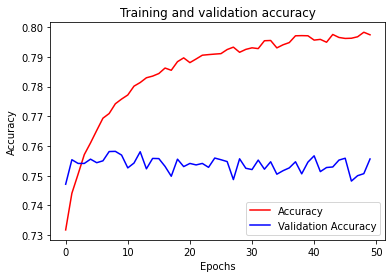

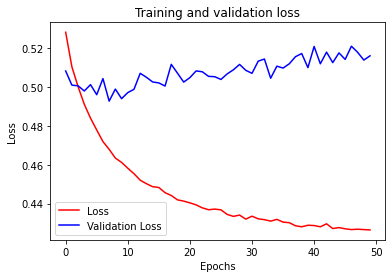

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!